## Web scrapping using python

#### References
1. [Practical Introduction to Web Scraping in Python](https://realpython.com/python-web-scraping-practical-introduction/)
2. [Web Scraping using Python](https://www.datacamp.com/community/tutorials/web-scraping-using-python)

In [2]:
# $ python3 -m venv venv
# $ . ./venv/bin/activate

In [3]:
#Better
#!pip install requests BeautifulSoup4 fire

In [1]:
#!pip install python-dotenv

In [2]:
from dotenv import load_dotenv, find_dotenv

In [3]:
# find .env automatically by walking up the directories until it's found
dotenv_path = find_dotenv()
# load up the entries as environment variables
load_dotenv(dotenv_path)

True

In [4]:
#imports
from requests import get
from requests.exceptions import RequestException
from contextlib import closing
from bs4 import BeautifulSoup

import os, sys
import fire

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()



In [5]:
#%%writefile ../pyscrap_url.py

def simple_get(url):
    """
    Attempts to get the content at `url` by making an HTTP GET request.
    If the content-type of response is some kind of HTML/XML, return the
    text content, otherwise return None.
    """
    try:
        with closing(get(url, stream=True)) as resp:
            if is_good_response(resp):
                return resp.content  #.encode(BeautifulSoup.original_encoding)
            else:
                return None

    except RequestException as e:
        log_error('Error during requests to {0} : {1}'.format(url, str(e)))
        return None


def is_good_response(resp):
    """
    Returns True if the response seems to be HTML, False otherwise.
    """
    content_type = resp.headers['Content-Type'].lower()
    return (resp.status_code == 200 
            and content_type is not None 
            and content_type.find('html') > -1)


def log_error(e):
    """
    It is always a good idea to log errors. 
    This function just prints them, but you can
    make it do anything.
    """
    print(e)
    
def get_elements(url, tag='',search={}, fname=None):
    """
    Downloads a page specified by the url parameter
    and returns a list of strings, one per tag element
    """
    
    if isinstance(url,str):
        response = simple_get(url)
    else:
        #if already it is a loaded html page
        response = url

    if response is not None:
        html = BeautifulSoup(response, 'html.parser')
        
        res = []
        if tag:    
            for li in html.select(tag):
                for name in li.text.split('\n'):
                    if len(name) > 0:
                        res.append(name.strip())
                       
                
        if search:
            soup = html            
            
            
            r = ''
            if 'find' in search.keys():
                print('findaing',search['find'])
                soup = soup.find(**search['find'])
                r = soup

                
            if 'find_all' in search.keys():
                print('finding all of',search['find_all'])
                r = soup.find_all(**search['find_all'])
   
            if r:
                for x in list(r):
                    if len(x) > 0:
                        res.extend(x)
            
        return res

    # Raise an exception if we failed to get any data from the url
    raise Exception('Error retrieving contents at {}'.format(url))    
    
    
if get_ipython().__class__.__name__ == '__main__':
    fire(get_tag_elements)

### Scraping the data for the top 100 most influential twitter users in Africa

In [7]:
res = get_elements('https://africafreak.com/100-most-influential-twitter-users-in-africa',tag='h2')


### Saving the top 10 most influential twitter users to a CSV file

In [8]:
new = pd.DataFrame(res).head(100)
new
#Data manipulation
df1 = new[0].str.split('.', expand=True)
df1.head(100)
df2 = df1[1].str.split('(', expand=True)
df2.head(100)
df2[1] = df2[1].str.strip(')')
df2.head(100)
df2.columns = ['Twitter_name','Twitter_handle']

twitter_handle = df2["Twitter_handle"].astype(str).tolist()

twitter_handle

['@gettleman',
 '@a24media',
 '@andiMakinana',
 '@AfricaCheck',
 '@JamesCopnall',
 '@oafrica',
 '@PatrickNgowi',
 '@StateAfrica',
 '@Moadow',
 '@BrendanSAfrica',
 '@CityTshwane',
 '@VISI_Mag',
 '@andBeyondSafari',
 '@ThisIsAfricaTIA',
 '@sarzss',
 '@TheEIU_Africa',
 '@InvestInAfrica',
 '@malonebarry',
 '@artsouthafrica',
 '@KahnMorbee',
 '@JamalMOsman',
 '@iamsuede',
 '@mikestopforth',
 '@equal_education',
 '@t_mcconnell',
 '@forbeesta',
 '@hurricanevaness',
 '@BBCKarenAllen',
 '@jaxpanik',
 '@thisisafrica',
 '@audisouthafrica',
 '@ONEinAfrica',
 '@Hamza_Africa',
 '@drewfhinshaw',
 '@africatechie',
 '@cx73',
 '@ayittey',
 '@MercedesBenz_SA',
 '@africagathering',
 '@okayafrica',
 '@mary_harper',
 '@savetherhino',
 '@africamedia_CPJ',
 '@TechCentral',
 '@GautengProvince',
 '@Aynte',
 '@daniel_howden',
 '@rangerdiaries',
 '@TheStar_news',
 '@schneiderhome',
 '@Afrinnovator',
 '@theafricareport',
 '@CityofJoburgZA',
 '@ThinkAfricaFeed',
 '@AfricaGoodNews',
 '@willintune',
 '@cnbcafrica',
 

### Script for mining twitter user's data by user_timeline.

In [6]:
from __future__ import unicode_literals
import sys
import os
import json 
import re
import string

import matplotlib.dates as mdates


# to view all columns
pd.set_option("display.max.columns", None)

# Import the necessary methods from tweepy library

import tweepy
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream

# Sentiment analysis package
from textblob import TextBlob

# general text pre-processor

import nltk
from nltk.corpus import stopwords
#nltk.download('punkt')

# tweet pre-processor
import preprocessor as p

'''
def print_full(x):
     # This is to print nicely DataFrame wide tables
    pd.set_option('display.max_rows', len(x))
    pd.set_option('display')'

'''

class tweetsearch():

    def __init__(self, cols=None, auth=None):

        if not cols is None:
            self.cols = cols
        else:
            self.cols = [
                'id', 'created_at', 'source', 'original_text', 'clean_text',
                'sentiment', 'polarity', 'subjectivity','lang','favorite_count', 
                'retweet_count','original_author', 'hashtgs','user_mentions',
                'followers', 'following', 'place_coordinates', 'place'
            ]

        if auth is None:             
            
            consumer_key = os.environ.get('TWITTER_API_KEY')
            consumer_secret = os.environ.get('TWITTER_API_SECRET')
            access_token = os.environ.get('TWITTER_ACCESS_TOKEN')
            access_token_secret = os.environ.get('TWITTER_ACCESS_TOKEN_SECRET')

            # This handles Twitter authentication 
            auth = OAuthHandler(consumer_key, consumer_secret)
            auth.set_access_token(access_token, access_token_secret)

        self.auth = auth
        self.api = tweepy.API(auth, wait_on_rate_limit=True)
        self.filtered_tweet = ''

    def clean_tweets(self, twitter_text):

        # use pre processor
        tweet = p.clean(twitter_text)

        #Happy Emoticons
        emoticons_happy = set([
            ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
            ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
            '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
            'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
            '<3'
            ])

        # Sad Emoticons
        emoticons_sad = set([
            ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
            ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
            ':c', ':{', '>:\\', ';('
            ])

        #Emoji patterns
        emoji_pattern = re.compile("["
                 u"\U0001F600-\U0001F64F"  # emoticons
                 u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                 u"\U0001F680-\U0001F6FF"  # transport & map symbols
                 u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                 u"\U00002702-\U000027B0"
                 u"\U000024C2-\U0001F251"
                 "]+", flags=re.UNICODE)

        # combine sad and happy emoticons
        emoticons = emoticons_happy.union(emoticons_sad)

        stop_words = set(stopwords.words('english'))
        word_tokens = nltk.word_tokenize(tweet)

        tweet = re.sub(r':', '', tweet)
        tweet = re.sub(r'‚Ä¶', '', tweet)

        #replace consecutive non-ASCII characters with a space
        tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)

        #remove emojis from tweet
        tweet = emoji_pattern.sub(r'', tweet)

        #filter using NLTK library append it to a string
        filtered_tweet = [w for w in word_tokens if not w in stop_words]

        # looping through conditions
        filtered_tweet = []
        for w in word_tokens:
            # check tokens againts stop words, emoticons and punctuations
            if w not in stop_words and w not in emoticons and w not in string.punctuation:
                filtered_tweet.append(w)

        return ' '.join(filtered_tweet)

    def get_tweets(self, name, csvfile=None):

        df = pd.DataFrame(columns=self.cols)

        if not csvfile is None:
            # If the file exists, then read the existing data from the CSV file
            if os.path.exists(csvfile):
                df = pd.read_csv(csvfile, header=0)
                
        

        # page attribute in tweepy.cursor and iteration
        for page in tweepy.Cursor(self.api.user_timeline, id=name).pages(1):

            for status in page:
                new_entry = []
                status = status._json

                # filter by language
                #if status['lang'] != 'en':
                 #   continue

                # if this tweet is a retweet update retweet count
                if status['created_at'] in df['created_at'].values:
                    i = df.loc[df['created_at'] == status['created_at']].index[0]

                    cond1 = status['favorite_count'] != df.at[i, 'favorite_count']
                    cond2 = status['retweet_count'] != df.at[i, 'retweet_count']
                    if cond1 or cond2:
                        df.at[i, 'favorite_count'] = status['favorite_count']
                        df.at[i, 'retweet_count'] = status['retweet_count']
                    continue

                # calculate sentiment
                filtered_tweet = self.clean_tweets(status['text'])
                blob = TextBlob(filtered_tweet)
                Sentiment = blob.sentiment
                polarity = Sentiment.polarity
                subjectivity = Sentiment.subjectivity

                new_entry += [status['id'], status['created_at'],
                              status['source'], status['text'], filtered_tweet,
                              Sentiment, polarity, subjectivity, status['lang'],
                              status['favorite_count'], status['retweet_count']]


                new_entry.append(status['user']['screen_name'])

                hashtags = ", ".join([hashtag_item['text'] for hashtag_item in status['entities']['hashtags']])
                new_entry.append(hashtags) # append the hashtags

                mentions = ", ".join([mention['screen_name'] for mention in status['entities']['user_mentions']])
                new_entry.append(mentions) # append user mentions

                try:
                    followers = status['user']['followers_count']
                except TypeError:
                    followers = None

                new_entry.append(followers)

                try: 
                    following = status['user']['friends_count']
                except TypeError:
                    following = None

                new_entry.append(following)


                try:
                    xyz = status['place']['bounding_box']['coordinates']
                    coordinates = [coord for loc in xyz for coord in loc]
                except TypeError:
                    coordinates = None

                new_entry.append(coordinates)

                try:
                    location = status['user']['location']
                except TypeError:
                    location = ''

                new_entry.append(location)

                # appending a row to the data frame
                single_user_df = pd.DataFrame([new_entry], columns=self.cols)
                df = df.append(single_user_df, ignore_index=True)

        if not csvfile is None:
            df.to_csv(csvfile, columns=self.cols, index=False, encoding="utf-8")

        return df

In [14]:
tweetsfile = "influencer.json"

ts = tweetsearch()

for handle in twitter_handle:
    try:
        names = []
        u = api.get_user(user)
        names.append(u.screen_name)
    except Exception:
        pass

df_influencer = ts.get_tweets(handle, csvfile=tweetsfile)


In [16]:
df_influencer.to_csv("twitter_most_influencial_users.csv", index=False)

In [7]:
df_influencer = pd.read_csv("twitter_most_influencial_users.csv")

### Structure of DataFrame

In [8]:
df_influencer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 18 columns):
id                   240 non-null int64
created_at           240 non-null object
source               240 non-null object
original_text        240 non-null object
clean_text           231 non-null object
sentiment            240 non-null object
polarity             240 non-null float64
subjectivity         240 non-null float64
lang                 240 non-null object
favorite_count       240 non-null int64
retweet_count        240 non-null int64
original_author      240 non-null object
hashtgs              59 non-null object
user_mentions        166 non-null object
followers            240 non-null int64
following            240 non-null int64
place_coordinates    0 non-null float64
place                180 non-null object
dtypes: float64(3), int64(5), object(10)
memory usage: 33.9+ KB


### Summary statistics of the dataframe

In [9]:
df_influencer.describe(include='all')

,id,created_at,source,original_text,clean_text,sentiment,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,hashtgs,user_mentions,followers,following,place_coordinates,place
count,2.400000e+02,240,240,240,231,240,240.000000,240.000000,240,240.000000,240.000000,240,59,166,2.400000e+02,240.000000,0.0,180
unique,NaN,240,10,240,231,113,NaN,NaN,10,NaN,NaN,13,44,141,NaN,NaN,NaN,10
top,NaN,Thu Jul 09 07:20:00 +0000 2020,"<a href=""https://mobile.twitter.com"" rel=""nofo...",@DHLAfrica I am one disappointed customer! My ...,The biggest star Bollywood one India 's revere...,"Sentiment(polarity=0.0, subjectivity=0.0)",NaN,NaN,en,NaN,NaN,CityTshwane,COVID19,Yebo_Live,NaN,NaN,NaN,South Africa- Gauteng
freq,NaN,1,73,1,1,96,NaN,NaN,218,NaN,NaN,22,6,7,NaN,NaN,NaN,22
mean,1.187873e+18,NaN,NaN,NaN,NaN,NaN,0.087943,0.304354,NaN,573.600000,3681.287500,NaN,NaN,NaN,9.763653e+05,2158.512500,NaN,NaN
std,1.809243e+17,NaN,NaN,NaN,NaN,NaN,0.228168,0.322371,NaN,4175.996102,18699.636271,NaN,NaN,NaN,2.971257e+06,1633.034901,NaN,NaN
min,6.955371e+17,NaN,NaN,NaN,NaN,NaN,-0.600000,0.000000,NaN,0.000000,0.000000,NaN,NaN,NaN,8.000000e+00,0.000000,NaN,NaN
25%,1.271255e+18,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0.000000,1.000000,NaN,NaN,NaN,2.570100e+04,325.000000,NaN,NaN
50%,1.282030e+18,NaN,NaN,NaN,NaN,NaN,0.000000,0.250000,NaN,0.000000,3.000000,NaN,NaN,NaN,5.098300e+04,2840.000000,NaN,NaN
75%,1.283871e+18,NaN,NaN,NaN,NaN,NaN,0.200000,0.502976,NaN,2.000000,20.250000,NaN,NaN,NaN,1.012690e+05,2927.000000,NaN,NaN


In [10]:
df_influencer.head()

,id,created_at,source,original_text,clean_text,sentiment,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,hashtgs,user_mentions,followers,following,place_coordinates,place
0,1282761976343662593,Mon Jul 13 19:41:02 +0000 2020,"<a href=""https://about.twitter.com/products/tw...",Actual video footage of me starting off the we...,Actual video footage starting week,"Sentiment(polarity=0.0, subjectivity=0.1)",0.00,0.10,en,20723,2738,Trevornoah,NaN,NaN,10802853,325,NaN,"New York, NY"
1,1282073950843858944,Sat Jul 11 22:07:04 +0000 2020,"<a href=""https://mobile.twitter.com"" rel=""nofo...",RT @KingBach: https://t.co/Sj2sVP7Gdt,NaN,"Sentiment(polarity=0.0, subjectivity=0.0)",0.00,0.00,und,0,92890,Trevornoah,NaN,KingBach,10802853,325,NaN,"New York, NY"
2,1280514534155923459,Tue Jul 07 14:50:30 +0000 2020,"<a href=""https://mobile.twitter.com"" rel=""nofo...",When white people take “being an ally” too far...,When white people take ally far,"Sentiment(polarity=0.05, subjectivity=0.5)",0.05,0.50,en,43358,6001,Trevornoah,NaN,NaN,10802853,325,NaN,"New York, NY"
3,1280258784485572611,Mon Jul 06 21:54:14 +0000 2020,"<a href=""https://mobile.twitter.com"" rel=""nofo...",Me at the restaurant after things return to no...,Me restaurant things return normal,"Sentiment(polarity=0.15, subjectivity=0.649999...",0.15,0.65,en,14667,1639,Trevornoah,NaN,NaN,10802853,325,NaN,"New York, NY"
4,1276561514456113152,Fri Jun 26 17:02:37 +0000 2020,"<a href=""http://twitter.com/download/iphone"" r...",RT @franklinleonard: “I have rape-colored skin...,I rape-colored skin,"Sentiment(polarity=0.0, subjectivity=0.0)",0.00,0.00,en,0,405,Trevornoah,NaN,franklinleonard,10802853,325,NaN,"New York, NY"


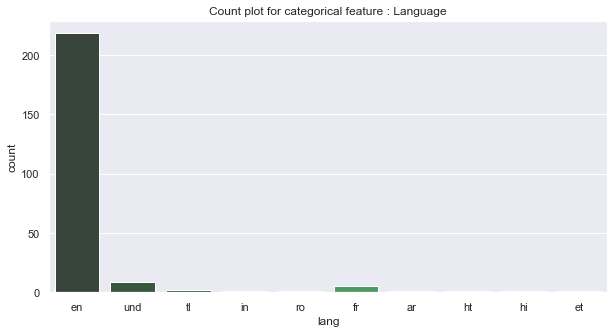

In [11]:
plt.figure(figsize=(10,5))
cplot = sns.countplot(x='lang', data=df_influencer, palette="Greens_d")
cplot.set(title="Count plot for categorical feature : Language")
plt.show()

### Finding popularity score for the Africa twitter influencers

In [12]:
# Creating a sample dataframe containing the columns : favorite_count, retweet_count and original_author
popularity_df = df_influencer[['original_author','favorite_count','retweet_count']]

# Grouping the columns using original author and finding summation
popularity_df = popularity_df.groupby(['original_author'])['favorite_count', 'retweet_count'].sum()

# Finding a total of favorite and retweet counts per author
popularity_col = popularity_df['favorite_count'] + popularity_df['retweet_count']

# Creating a column for the summation of favorite and retweet counts per author.
popularity_df["popularity_col"] = popularity_col

# Sorting the dataframe with the popularity column
pop_score_twitter_influencers = popularity_df.sort_values("popularity_col", ascending=False)

In [13]:
pop_score_twitter_influencers

,favorite_count,retweet_count,popularity_col
original_author,,,
Trevornoah,136472,760010,896482
gettleman,126,110767,110893
JamesCopnall,95,3605,3700
AndiMakinana,496,2923,3419
PatrickNgowi,0,1999,1999
BrendanSAfrica,262,1555,1817
CityTshwane,68,1655,1723
Moadow,18,512,530
oafrica,18,372,390


In [14]:
pop_score_twitter_influencers = pop_score_twitter_influencers.reset_index()

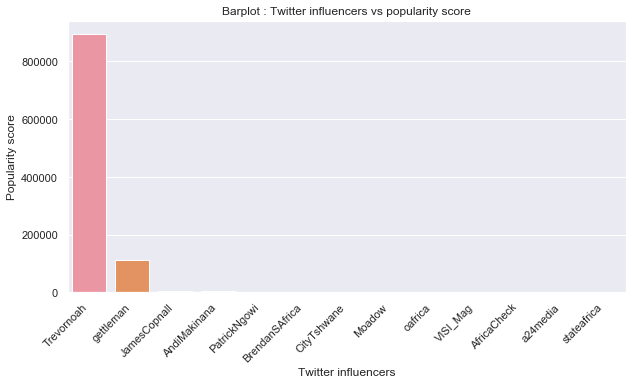

In [15]:
plt.figure(figsize=(10,5))
plot = sns.barplot(x="original_author", y="popularity_col", data=pop_score_twitter_influencers)
plot.set_xticklabels(plot.get_xticklabels(), rotation=45, horizontalalignment='right')
plot.set(xlabel="Twitter influencers", ylabel="Popularity score", title="Barplot : Twitter influencers vs popularity score")
plt.show()

### Finding reach score for Africa twitter influencers

In [16]:
# Creating a sample dataframe containing the columns : followers, following and original_author
reach_df = df_influencer[['original_author','followers','following']]

# Grouping the columns using original author and finding summation
reach_df = reach_df.groupby(['original_author'])['followers', 'following'].sum() 

# Finding a total of followers and following counts per author
reach_col = reach_df['followers'] + reach_df['following']

# Creating a column for the summation of followers and following counts per author.
reach_df["reach_col"] = reach_col

# Sorting the dataframe with the popularity column
reach_score_twitter_influencers = reach_df.sort_values("reach_col", ascending=False)

In [17]:
reach_score_twitter_influencers

,followers,following,reach_col
original_author,,,
Trevornoah,216057060,6500,216063560
CityTshwane,9664352,64394,9728746
AndiMakinana,2025380,56800,2082180
AfricaCheck,1361400,91820,1453220
VISI_Mag,1057960,36380,1094340
Moadow,1019660,34640,1054300
oafrica,625900,57520,683420
a24media,594472,58121,652593
JamesCopnall,439220,100960,540180


In [18]:
reach_score_twitter_influencers = reach_score_twitter_influencers.reset_index()

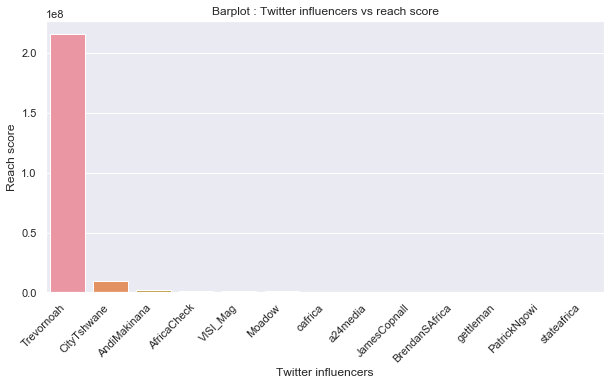

In [19]:
plt.figure(figsize=(10,5))
plot = sns.barplot(x="original_author", y="reach_col", data=reach_score_twitter_influencers)
plot.set_xticklabels(plot.get_xticklabels(), rotation=45, horizontalalignment='right')
plot.set(xlabel="Twitter influencers", ylabel="Reach score", 
         title="Barplot : Twitter influencers vs reach score")
plt.show()

### Finding the relevance score for Africa twitter influencers

In [20]:
relevance_df = df_influencer[['original_author','user_mentions']]

In [21]:
relevance_df = relevance_df.groupby('original_author').count()
relevance_df

,user_mentions
original_author,
AfricaCheck,7
AndiMakinana,7
BrendanSAfrica,12
CityTshwane,16
JamesCopnall,19
Moadow,18
PatrickNgowi,20
Trevornoah,16
VISI_Mag,12


In [22]:
rel_score_twitter_influencers = relevance_df.sort_values('user_mentions', ascending=False)
rel_score_twitter_influencers

,user_mentions
original_author,
PatrickNgowi,20
JamesCopnall,19
Moadow,18
CityTshwane,16
Trevornoah,16
gettleman,14
oafrica,13
BrendanSAfrica,12
VISI_Mag,12


In [23]:
rel_score_twitter_influencers = rel_score_twitter_influencers .reset_index()

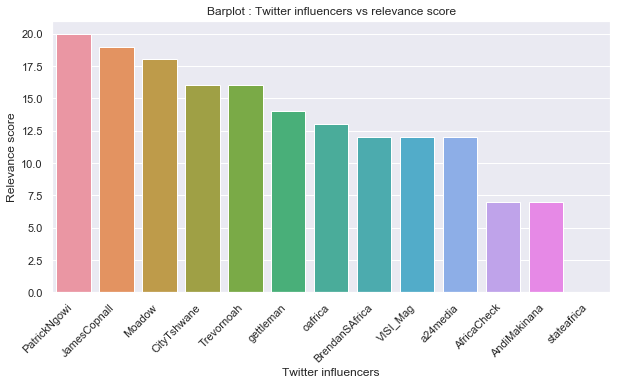

In [24]:
plt.figure(figsize=(10,5))
plot = sns.barplot(x="original_author", y="user_mentions", data=rel_score_twitter_influencers)
plot.set_xticklabels(plot.get_xticklabels(), rotation=45, horizontalalignment='right')
plot.set(xlabel="Twitter influencers", ylabel="Relevance score", 
         title="Barplot : Twitter influencers vs relevance score")
plt.show()

### Extracting top 5 unique hashtags for Africa twitter influencers

In [25]:
# dropping nan values for hashtag column
df_influencer.dropna(subset= ["hashtgs"], inplace=True)

In [26]:
hashtags_df = df_influencer[['original_author','retweet_count','hashtgs']]

In [27]:
top_hashtag = hashtags_df.groupby('original_author').head(10)
top_hashtag

,original_author,retweet_count,hashtgs
19,Trevornoah,894,BlackPeoplePenance
29,gettleman,3,"PLA, IndianArmy"
34,gettleman,1,COVID19
41,a24media,3,"YeboWatchParty, KenSaroWiwa"
45,a24media,2,"KenSaroWiwa, YeboWatchParty"
47,a24media,2,YeboWatchParty
52,a24media,8,YeboWatchParty
63,AndiMakinana,1,Overheard
79,AfricaCheck,2,"scams, SouthAfrican"
80,AfricaCheck,1,COVID19


In [28]:
top_hashtag = top_hashtag.groupby('hashtgs').count()

In [29]:
top_hashtag = top_hashtag.sort_values('retweet_count', ascending=False)

In [30]:
top_hashtag.head()

,original_author,retweet_count
hashtgs,,
COVID19,6,6
FYI,4,4
"COVID19, COVIDConnect",3,3
Sudan,2,2
MandelaDay2020,2,2


In [31]:
top5_hashtags = top_hashtag.index.values[0:5]

In [32]:
top5_hashtags_twt_influencers = pd.DataFrame(top5_hashtags)

In [33]:
top5_hashtags_twt_influencers.columns = ['Top 5 hashtags'] 

In [34]:
top5_hashtags_twt_influencers

,Top 5 hashtags
0,COVID19
1,FYI
2,"COVID19, COVIDConnect"
3,Sudan
4,MandelaDay2020


In [36]:
top5_hashtags_influencers = df_influencer.loc[((df_influencer['hashtgs'] == 'COVID19')|
                                               (df_influencer['hashtgs'] == 'FYI')|
                                               (df_influencer['hashtgs'] == 'COVID19, COVIDConnect')|
                                               (df_influencer['hashtgs'] == 'Sudan')|
                                               (df_influencer['hashtgs'] == 'MandelaDay2020'))]

In [38]:
top5_hashtags_influencers

,id,created_at,source,original_text,clean_text,sentiment,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,hashtgs,user_mentions,followers,following,place_coordinates,place
34,1275984137812230144,Thu Jun 25 02:48:19 +0000 2020,"<a href=""http://twitter.com/download/iphone"" r...","RT @IDFCinstitute: @nytimes, @gettleman and @s...",look tragic story New Delhi highlights strain,"Sentiment(polarity=-0.3068181818181818, subjec...",-0.306818,0.602273,en,0,1,gettleman,COVID19,"IDFCinstitute, nytimes, gettleman, suhasiniraj",25701,37,NaN,"New Delhi, India"
80,1284064062549250050,Fri Jul 17 09:55:03 +0000 2020,"<a href=""https://about.twitter.com/products/tw...",@KasMedia The programme will be conducted in F...,The programme conducted French depending trave...,"Sentiment(polarity=0.0, subjectivity=0.0)",0.000000,0.000000,en,0,1,AfricaCheck,COVID19,KasMedia,68070,4591,NaN,NaN
86,1283751739175337986,Thu Jul 16 13:14:00 +0000 2020,"<a href=""https://about.twitter.com/products/tw...",#FYI: Here is some useful reading material to ...,Here useful reading material help sort fact fi...,"Sentiment(polarity=0.3, subjectivity=0.0)",0.300000,0.000000,en,0,0,AfricaCheck,FYI,NaN,68070,4591,NaN,NaN
88,1283736388194705408,Thu Jul 16 12:13:00 +0000 2020,"<a href=""https://about.twitter.com/products/tw...",#FYI: Here are some things to look out for whe...,Here things look trying recognise fake AI gene...,"Sentiment(polarity=-0.5, subjectivity=1.0)",-0.500000,1.000000,en,1,0,AfricaCheck,FYI,NaN,68070,4591,NaN,NaN
92,1283718020611923969,Thu Jul 16 11:00:01 +0000 2020,"<a href=""https://about.twitter.com/products/tw...",#FYI: The comment section on a social media po...,The comment section social media post valuable...,"Sentiment(polarity=0.03333333333333333, subjec...",0.033333,0.066667,en,0,0,AfricaCheck,FYI,NaN,68070,4591,NaN,NaN
97,1283691593136926721,Thu Jul 16 09:15:00 +0000 2020,"<a href=""https://about.twitter.com/products/tw...",#FYI: Genuine unedited or manipulated videos ...,Genuine unedited manipulated videos also share...,"Sentiment(polarity=0.4, subjectivity=0.5)",0.400000,0.500000,en,0,1,AfricaCheck,FYI,NaN,68070,4591,NaN,NaN
108,1282030123764592641,Sat Jul 11 19:12:55 +0000 2020,"<a href=""http://twitter.com/download/iphone"" r...",RT @wasilalitaha: MORE: @nasabdulbari says the...,MORE says new legal amendments mean non-Muslim...,"Sentiment(polarity=0.1309659090909091, subject...",0.130966,0.460511,en,0,40,JamesCopnall,Sudan,"wasilalitaha, nasabdulbari",21961,5048,NaN,NaN
109,1282030081947426817,Sat Jul 11 19:12:45 +0000 2020,"<a href=""http://twitter.com/download/iphone"" r...",RT @wasilalitaha: BREAKING: #Sudan justice min...,BREAKING justice minister confirms government ...,"Sentiment(polarity=0.0, subjectivity=0.0)",0.000000,0.000000,en,0,134,JamesCopnall,Sudan,"wasilalitaha, nasabdulbari",21961,5048,NaN,NaN
160,1283770674918707201,Thu Jul 16 14:29:14 +0000 2020,"<a href=""http://twitter.com/download/android"" ...",RT @YvonneNdege: The economic hit on remittanc...,The economic hit remittances Afric esp Kenya S...,"Sentiment(polarity=0.1, subjectivity=0.6)",0.100000,0.600000,en,0,1,Moadow,COVID19,YvonneNdege,50983,1732,NaN,"Doha, Qatar"
199,1284204579215888384,Fri Jul 17 19:13:25 +0000 2020,"<a href=""http://twitter.com/download/android"" ...","RT @DrZweliMkhize: As of today, the total numb...",As today total number confirmed cases total nu...,"Sentiment(polarity=0.1, subjectivity=0.8125)",0.100000,0.812500,en,0,274,CityTshwane,COVID19,DrZweliMkhize,439288,2927,NaN,South Africa- Gauteng


In [39]:
top5_hashtags_influence = top5_hashtags_influencers.groupby('hashtgs').count()

In [40]:
top5_hashtags_influence

,id,created_at,source,original_text,clean_text,sentiment,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,user_mentions,followers,following,place_coordinates,place
hashtgs,,,,,,,,,,,,,,,,,
COVID19,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,0,5
"COVID19, COVIDConnect",3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,0,3
FYI,4,4,4,4,4,4,4,4,4,4,4,4,0,4,4,0,0
MandelaDay2020,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,0,2
Sudan,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0


In [41]:
top5_hashtags_influence = top5_hashtags_influence.reset_index()

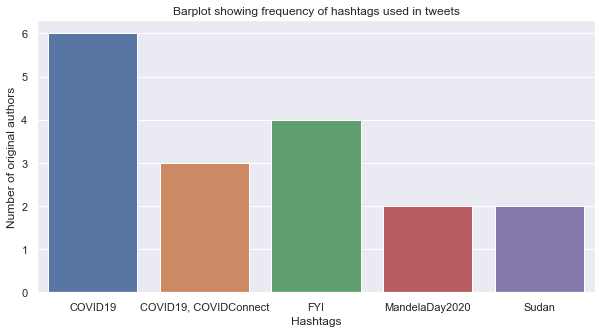

In [43]:
plt.figure(figsize=(10,5))
bplot = sns.barplot(x="hashtgs", y="original_author", data=top5_hashtags_influence)
bplot.set(xlabel="Hashtags", ylabel="Number of original authors", 
          title="Barplot showing frequency of hashtags used in tweets")
plt.show()

### Getting the data for African leaders response to corona virus

### East Africa Region

In [16]:
import re
url= 'https://www.atlanticcouncil.org/blogs/africasource/african-leaders-respond-to-coronavirus-on-twitter/#east-africa'
response = simple_get(url)
res_east_africa = get_elements(response, search={'find_all':{'class_':'twitter-tweet'}})
mystrings = []
for tag in res_east_africa:
    if tag.string != None:
        mystrings.append(tag.string)
        
# Extracting specific twitter handles
my_regex = re.compile(r'@[a-zA-Z0-9_]{0,15}')
tags = ''.join(mystrings)
twitter_handles = my_regex.findall(tags)
twitter_handles = pd.DataFrame(twitter_handles)

twitter_handles.columns = ["Twitter_handle"]

twitter_handles_east_africa = twitter_handles["Twitter_handle"].astype(str).tolist()
twitter_handles_east_africa


finding all of {'class_': 'twitter-tweet'}


['@EswatiniGovern1',
 '@MalawiGovt',
 '@hagegeingob',
 '@FinanceSC',
 '@PresidencyZA',
 '@mohzambia',
 '@edmnangagwa',
 '@MinSantedj',
 '@hawelti',
 '@StateHouseKenya',
 '@PaulKagame',
 '@M_Farmaajo',
 '@SouthSudanGov',
 '@SudanPMHamdok',
 '@TZSpokesperson',
 '@KagutaMuseveni',
 '@angola_Mirex',
 '@willynyamitwe',
 '@Cherif_MZ',
 '@Presidence_RDC',
 '@PresidentABO',
 '@PresidenceBenin',
 '@rochkaborepf',
 '@PresidenciaCV',
 '@AOuattara_PRCI',
 '@Presidency_GMB',
 '@NAkufoAddo',
 '@President_GN',
 '@USEmbalo',
 '@PresidenceMali',
 '@CheikhGhazouani',
 '@IssoufouMhm',
 '@MBuhari',
 '@Macky_Sall',
 '@PresidentBio',
 '@MSPS_Togo']

In [17]:
tweetsfile = "strictly_officials.json"

ts = tweetsearch()

for handle in twitter_handles_east_africa:
    
    df_gov = ts.get_tweets(handle, csvfile=tweetsfile)

In [18]:
df_gov.to_csv('goverment_officials.csv', index=False)

In [44]:
df_gov = pd.read_csv('goverment_officials.csv')

### Basic Structure of the Goverment Official dataset

In [45]:
# info function gives us a high overview of the dataset, number of entries, columns and data types of each column.
df_gov.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707 entries, 0 to 706
Data columns (total 18 columns):
id                   707 non-null int64
created_at           707 non-null object
source               707 non-null object
original_text        707 non-null object
clean_text           635 non-null object
sentiment            707 non-null object
polarity             707 non-null float64
subjectivity         707 non-null float64
lang                 707 non-null object
favorite_count       707 non-null int64
retweet_count        707 non-null int64
original_author      707 non-null object
hashtgs              179 non-null object
user_mentions        155 non-null object
followers            707 non-null int64
following            707 non-null int64
place_coordinates    16 non-null object
place                667 non-null object
dtypes: float64(2), int64(5), object(11)
memory usage: 99.5+ KB


In [46]:
# head function gives the first 5 rows of the dataframe
df_gov.head()

,id,created_at,source,original_text,clean_text,sentiment,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,hashtgs,user_mentions,followers,following,place_coordinates,place
0,1284166125312454656,Fri Jul 17 16:40:37 +0000 2020,"<a href=""http://twitter.com/download/android"" ...",Ministerial Statement: Minister of Health Lizz...,Ministerial Statement Minister Health Lizzie N...,"Sentiment(polarity=0.06818181818181818, subjec...",0.068182,0.602273,en,41,16,EswatiniGovern1,COVID19,NaN,11297,82,NaN,Eswatini
1,1283799918939975680,Thu Jul 16 16:25:27 +0000 2020,"<a href=""http://twitter.com/download/android"" ...",Minister of Health Lizzie Nkosi announces one ...,Minister Health Lizzie Nkosi announces one new...,"Sentiment(polarity=0.06818181818181818, subjec...",0.068182,0.602273,en,54,24,EswatiniGovern1,"COVID19, COVID19",NaN,11297,82,NaN,Eswatini
2,1283444273149620224,Wed Jul 15 16:52:14 +0000 2020,"<a href=""http://twitter.com/download/android"" ...",Ministerial Statement: Minister of Health Lizz...,Ministerial Statement Minister Health Lizzie N...,"Sentiment(polarity=0.06818181818181818, subjec...",0.068182,0.602273,en,28,13,EswatiniGovern1,COVID19,NaN,11297,82,NaN,Eswatini
3,1283332522777157632,Wed Jul 15 09:28:11 +0000 2020,"<a href=""https://mobile.twitter.com"" rel=""nofo...",Ambassador Aragones: “When this project is imp...,Ambassador Aragones When project implemented r...,"Sentiment(polarity=0.0, subjectivity=0.0)",0.000000,0.000000,en,9,2,EswatiniGovern1,NaN,NaN,11297,82,NaN,Eswatini
4,1283332518964600839,Wed Jul 15 09:28:10 +0000 2020,"<a href=""https://mobile.twitter.com"" rel=""nofo...",Ambassador Aragones: “This assistance is part ...,Ambassador Aragones This assistance part bigge...,"Sentiment(polarity=0.0, subjectivity=0.5)",0.000000,0.500000,en,12,2,EswatiniGovern1,COVID19,NaN,11297,82,NaN,Eswatini


### Summary Statistcs

In [47]:
df_gov.describe()

,id,polarity,subjectivity,favorite_count,retweet_count,followers,following
count,7.070000e+02,707.000000,707.000000,707.000000,707.000000,7.070000e+02,707.000000
mean,1.269598e+18,0.049322,0.153789,681.066478,144.619519,4.584951e+05,292.042433
std,4.393872e+16,0.177968,0.278985,1645.549780,443.911577,7.492906e+05,778.231252
min,8.513641e+17,-1.000000,0.000000,0.000000,0.000000,1.260000e+02,0.000000
25%,1.270464e+18,0.000000,0.000000,8.000000,6.000000,7.146000e+03,26.000000
50%,1.280634e+18,0.000000,0.000000,95.000000,28.000000,6.610000e+04,95.000000
75%,1.283129e+18,0.000000,0.245833,504.500000,95.500000,4.238050e+05,195.000000
max,1.284458e+18,0.850000,1.000000,16314.000000,6298.000000,3.270564e+06,4656.000000


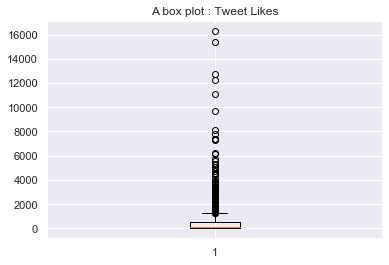

In [48]:
#box-whisker plot : tweet likes
plt.boxplot(df_gov.favorite_count);
plt.title('A box plot : Tweet Likes')

plt.show()

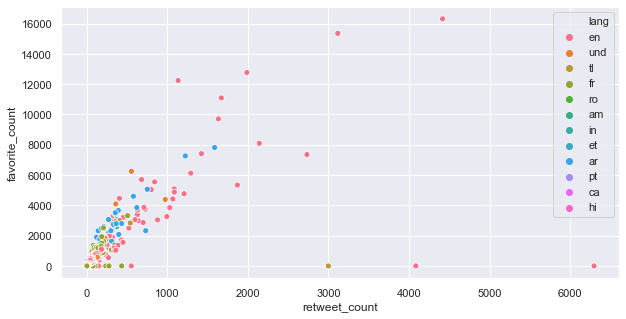

In [50]:
plt.figure(figsize=(10,5))
sns.scatterplot(x="retweet_count", y='favorite_count', hue="lang", data=df_gov)

plt.show()

### Finding popularity score for the government officials

In [51]:
# Creating a sample dataframe containing the columns : favorite_count, retweet_count and original_author
popularity_df = df_gov[['original_author','favorite_count','retweet_count']]

# Grouping the columns using original author and finding summation
popularity_df = popularity_df.groupby(['original_author'])['favorite_count', 'retweet_count'].sum()

# Finding a total of favorite and retweet counts per author
popularity_col = popularity_df['favorite_count'] + popularity_df['retweet_count']

# Creating a column for the summation of favorite and retweet counts per author.
popularity_df["popularity_col"] = popularity_col

# Sorting the dataframe with the popularity column
popularity_score_gov_officials = popularity_df.sort_values("popularity_col", ascending=False)

In [52]:
popularity_score_gov_officials

,favorite_count,retweet_count,popularity_col
original_author,,,
PaulKagame,106190,21772,127962
MBuhari,47927,10536,58463
CheikhGhazouani,50461,5752,56213
NAkufoAddo,43949,6058,50007
SudanPMHamdok,41983,6718,48701
M_Farmaajo,34210,5845,40055
edmnangagwa,30991,7196,38187
KagutaMuseveni,19121,2620,21741
Presidence_RDC,17343,2632,19975


In [53]:
popularity_score_gov_officials = popularity_score_gov_officials.reset_index()

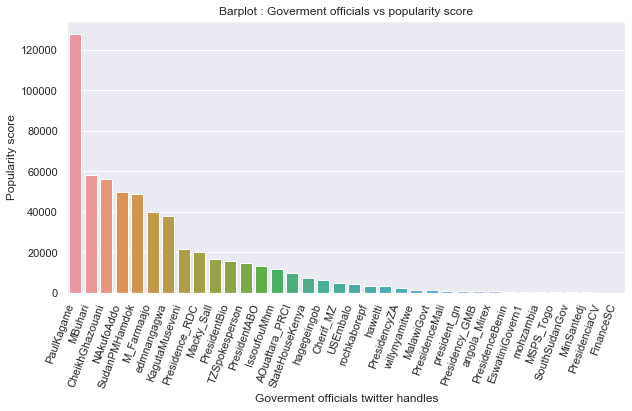

In [114]:
plt.figure(figsize=(10,5))
plot = sns.barplot(x="original_author", y="popularity_col", data=popularity_score_gov_officials)
plot.set_xticklabels(plot.get_xticklabels(), rotation=70, horizontalalignment='right')
plot.set(xlabel="Goverment officials twitter handles", ylabel="Popularity score", 
         title="Barplot : Goverment officials vs popularity score")
plt.savefig('popularity_score_gov.png', dpi=300, bbox_inches='tight')
plt.show()

### Finding reach score for the government officials

In [55]:
# Creating a sample dataframe containing the columns : followers, following and original_author
reach_df = df_gov[['original_author','followers','following']]

# Grouping the columns using original author and finding summation
reach_df = reach_df.groupby(['original_author'])['followers', 'following'].sum() 

# Finding a total of followers and following counts per author
reach_col = reach_df['followers'] + reach_df['following']

# Creating a column for the summation of followers and following counts per author.
reach_df["reach_col"] = reach_col

# Sorting the dataframe with the popularity column
reach_score_gov_officials = reach_df.sort_values("reach_col", ascending=False)

In [56]:
reach_score_gov_officials

,followers,following,reach_col
original_author,,,
MBuhari,65411280,520,65411800
PaulKagame,39656820,3620,39660440
KagutaMuseveni,36237680,560,36238240
PresidencyZA,31966980,280,31967260
NAkufoAddo,30131940,7040,30138980
Macky_Sall,27490840,3420,27494260
StateHouseKenya,18756185,3638,18759823
AOuattara_PRCI,16632980,460,16633440
edmnangagwa,9828126,2088,9830214


In [57]:
reach_score_gov_officials = reach_score_gov_officials.reset_index()

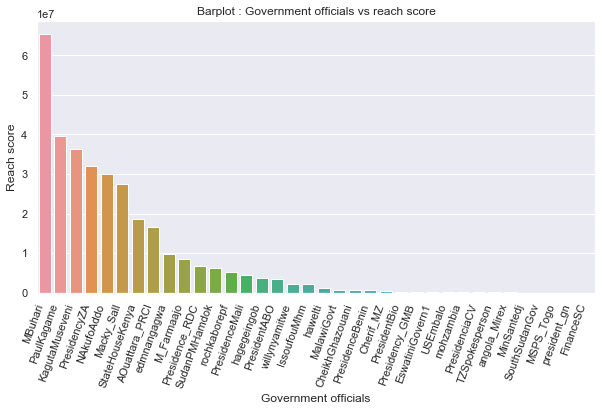

In [58]:
plt.figure(figsize=(10,5))
plot = sns.barplot(x="original_author", y="reach_col", data=reach_score_gov_officials)
plot.set_xticklabels(plot.get_xticklabels(), rotation=70, horizontalalignment='right')
plot.set(xlabel="Government officials", ylabel="Reach score", 
         title="Barplot : Government officials vs reach score")
plt.show()

### Finding the relevance score for the government officials

In [59]:
relevance_df = df_gov[['original_author','user_mentions']]

In [60]:
relevance_df = relevance_df.groupby('original_author').count()
relevance_df

,user_mentions
original_author,
AOuattara_PRCI,1
CheikhGhazouani,0
Cherif_MZ,3
EswatiniGovern1,1
FinanceSC,0
IssoufouMhm,3
KagutaMuseveni,2
MBuhari,0
MSPS_Togo,1


In [61]:
rel_score_gov_officials = relevance_df.sort_values('user_mentions', ascending=False)
rel_score_gov_officials 

,user_mentions
original_author,
willynyamitwe,14
USEmbalo,12
NAkufoAddo,11
MalawiGovt,11
TZSpokesperson,10
PresidenceBenin,9
Presidency_GMB,9
rochkaborepf,9
PaulKagame,9


In [62]:
rel_score_gov_officials = rel_score_gov_officials.reset_index()

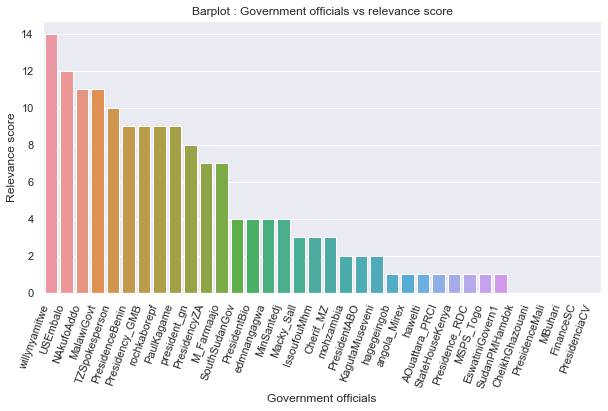

In [63]:
plt.figure(figsize=(10,5))
plot = sns.barplot(x="original_author", y="user_mentions", data=rel_score_gov_officials)
plot.set_xticklabels(plot.get_xticklabels(), rotation=70, horizontalalignment='right')
plot.set(xlabel="Government officials", ylabel="Relevance score", 
         title="Barplot : Government officials vs relevance score")
plt.show()

### Extracting top 5 unique hashtags for goverment officials

In [64]:
# dropping nan values for hashtag column
df_gov.dropna(subset= ["hashtgs"], inplace=True)

In [65]:
hashtags_df = df_gov[['original_author','retweet_count','hashtgs']]

In [66]:
top_hashtag = hashtags_df.groupby('original_author').head(10)
top_hashtag

,original_author,retweet_count,hashtgs
0,EswatiniGovern1,16,COVID19
1,EswatiniGovern1,24,"COVID19, COVID19"
2,EswatiniGovern1,13,COVID19
4,EswatiniGovern1,2,COVID19
8,EswatiniGovern1,10,COVID19
...,...,...,...
669,PresidentBio,62,SierraLeone
672,PresidentBio,31,COVID19
673,PresidentBio,42,DPGAlliance
681,PresidentBio,22,SierraLeone


In [67]:
top_hashtag = top_hashtag.groupby('hashtgs').count()

In [68]:
top_hashtag = top_hashtag.sort_values('retweet_count', ascending=False)

In [69]:
top_hashtag.head()

,original_author,retweet_count
hashtgs,,
COVID19,19,19
Eritrea,8,8
ConseildesMinistresSn,7,7
"RegisterToVote2020, 4MoreToDoMoreForYou",6,6
NelsonMandelaInternationalDay,6,6


In [70]:
top5_hashtags = top_hashtag.index.values[0:5]

In [71]:
top5_hashtags_gov_officials = pd.DataFrame(top5_hashtags)

In [72]:
top5_hashtags_gov_officials.columns = ['Top 5 hashtags'] 

In [73]:
top5_hashtags_gov_officials

,Top 5 hashtags
0,COVID19
1,Eritrea
2,ConseildesMinistresSn
3,"RegisterToVote2020, 4MoreToDoMoreForYou"
4,NelsonMandelaInternationalDay


In [74]:
top5_hashtags_gov_official_df = df_gov.loc[((df_gov['hashtgs'] == 'COVID19')|(df_gov['hashtgs'] == 'Eritrea')|
                           (df_gov['hashtgs'] == 'ConseildesMinistresSn')|
                           (df_gov['hashtgs'] == 'RegisterToVote2020, 4MoreToDoMoreForYou')|
                           (df_gov['hashtgs'] == 'NelsonMandelaInternationalDay'))]

In [79]:
top5_hashtags_gov_official_df

,index,id,created_at,source,original_text,clean_text,sentiment,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,hashtgs,user_mentions,followers,following,place_coordinates,place
0,0,1284166125312454656,Fri Jul 17 16:40:37 +0000 2020,"<a href=""http://twitter.com/download/android"" ...",Ministerial Statement: Minister of Health Lizz...,Ministerial Statement Minister Health Lizzie N...,"Sentiment(polarity=0.06818181818181818, subjec...",0.068182,0.602273,en,41,16,EswatiniGovern1,COVID19,NaN,11297,82,NaN,Eswatini
1,2,1283444273149620224,Wed Jul 15 16:52:14 +0000 2020,"<a href=""http://twitter.com/download/android"" ...",Ministerial Statement: Minister of Health Lizz...,Ministerial Statement Minister Health Lizzie N...,"Sentiment(polarity=0.06818181818181818, subjec...",0.068182,0.602273,en,28,13,EswatiniGovern1,COVID19,NaN,11297,82,NaN,Eswatini
2,4,1283332518964600839,Wed Jul 15 09:28:10 +0000 2020,"<a href=""https://mobile.twitter.com"" rel=""nofo...",Ambassador Aragones: “This assistance is part ...,Ambassador Aragones This assistance part bigge...,"Sentiment(polarity=0.0, subjectivity=0.5)",0.000000,0.500000,en,12,2,EswatiniGovern1,COVID19,NaN,11297,82,NaN,Eswatini
3,8,1283317063767990272,Wed Jul 15 08:26:45 +0000 2020,"<a href=""http://twitter.com/download/android"" ...",[WATCH LIVE]: Prime Minister Ambrose Mandvulo ...,WATCH LIVE Prime Minister Ambrose Mandvulo Dla...,"Sentiment(polarity=0.06818181818181818, subjec...",0.068182,0.250000,en,27,10,EswatiniGovern1,COVID19,NaN,11297,82,NaN,Eswatini
4,9,1283074517108174848,Tue Jul 14 16:22:57 +0000 2020,"<a href=""http://twitter.com/download/android"" ...",Ministerial Statement: Minister of Health Lizz...,Ministerial Statement Minister Health Lizzie N...,"Sentiment(polarity=0.06818181818181818, subjec...",0.068182,0.602273,en,49,15,EswatiniGovern1,COVID19,NaN,11297,82,NaN,Eswatini
5,13,1282717602263990272,Mon Jul 13 16:44:42 +0000 2020,"<a href=""http://twitter.com/download/android"" ...",Ministerial Statement: Minister of Health Lizz...,Ministerial Statement Minister Health Lizzie N...,"Sentiment(polarity=0.06818181818181818, subjec...",0.068182,0.602273,en,39,16,EswatiniGovern1,COVID19,NaN,11297,82,NaN,Eswatini
6,14,1282691147018784768,Mon Jul 13 14:59:35 +0000 2020,"<a href=""http://twitter.com/download/android"" ...",Minister of Tourism Moses Vilakati has launche...,Minister Tourism Moses Vilakati launched healt...,"Sentiment(polarity=0.0, subjectivity=0.0)",0.000000,0.000000,en,23,6,EswatiniGovern1,COVID19,NaN,11297,82,NaN,Eswatini
7,80,1284385081709092864,Sat Jul 18 07:10:40 +0000 2020,"<a href=""https://about.twitter.com/products/tw...",President @CyrilRamaphosa will join the rest o...,President join rest world marking annual toda,"Sentiment(polarity=0.0, subjectivity=0.0)",0.000000,0.000000,en,191,53,PresidencyZA,NelsonMandelaInternationalDay,CyrilRamaphosa,1598349,14,NaN,"Pretoria, South Africa"
8,81,1284150542034403330,Fri Jul 17 15:38:42 +0000 2020,"<a href=""http://twitter.com/download/android"" ...",The Presidency celebrates #NelsonMandelaIntern...,The Presidency celebrates donating blankets te...,"Sentiment(polarity=0.0, subjectivity=0.0)",0.000000,0.000000,en,15,6,PresidencyZA,NelsonMandelaInternationalDay,NaN,1598349,14,NaN,"Pretoria, South Africa"
9,83,1284146897234661376,Fri Jul 17 15:24:13 +0000 2020,"<a href=""http://twitter.com/download/android"" ...",The Presidency celebrates #NelsonMandelaIntern...,The Presidency celebrates donating blankets te...,"Sentiment(polarity=0.0, subjectivity=0.0)",0.000000,0.000000,en,21,8,PresidencyZA,NelsonMandelaInternationalDay,NaN,1598349,14,NaN,"Pretoria, South Africa"


In [80]:
top5_hashtags_gov = top5_hashtags_gov_official_df.groupby('hashtgs').count()

In [81]:
top5_hashtags_gov

,index,id,created_at,source,original_text,clean_text,sentiment,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,user_mentions,followers,following,place_coordinates,place
hashtgs,,,,,,,,,,,,,,,,,,
COVID19,20,20,20,20,20,20,20,20,20,20,20,20,20,3,20,20,3,20
ConseildesMinistresSn,7,7,7,7,7,0,7,7,7,7,7,7,7,0,7,7,0,7
Eritrea,8,8,8,8,8,8,8,8,8,8,8,8,8,0,8,8,0,8
NelsonMandelaInternationalDay,6,6,6,6,6,6,6,6,6,6,6,6,6,1,6,6,0,6
"RegisterToVote2020, 4MoreToDoMoreForYou",8,8,8,8,8,1,8,8,8,8,8,8,8,6,8,8,0,8


In [84]:
top5_hashtags_gov = top5_hashtags_gov.reset_index()

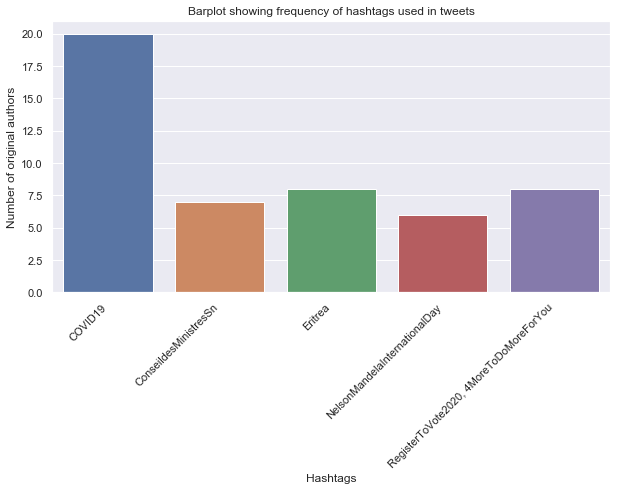

In [87]:
plt.figure(figsize=(10,5))
bplot = sns.barplot(x="hashtgs", y="original_author", data=top5_hashtags_gov)
bplot.set_xticklabels(bplot.get_xticklabels(), rotation=45, horizontalalignment='right')
bplot.set(xlabel="Hashtags", ylabel="Number of original authors", 
          title="Barplot showing frequency of hashtags used in tweets")
plt.show()

### Joining goverment official and tweeter influencers dataframes

In [100]:
df = pd.concat((df_influencer, df_gov), axis=0)

In [101]:
df

,id,created_at,source,original_text,clean_text,sentiment,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,hashtgs,user_mentions,followers,following,place_coordinates,place
19,1271219970224111618,Thu Jun 11 23:17:13 +0000 2020,"<a href=""http://twitter.com/download/iphone"" r...",RT @TaranaBurke: While companies are rushing t...,While companies rushing I need STOP listing en...,"Sentiment(polarity=0.0, subjectivity=0.0)",0.000000,0.000000,en,0,894,Trevornoah,BlackPeoplePenance,"TaranaBurke, Ancestry",10802853,325,NaN,"New York, NY"
29,1282365636279074817,Sun Jul 12 17:26:07 +0000 2020,"<a href=""https://mobile.twitter.com"" rel=""nofo...",RT @RLAnalytica: https://t.co/TRWynhS8eu\n\nQu...,raised preparedness provoking led,"Sentiment(polarity=0.0, subjectivity=0.0)",0.000000,0.000000,en,0,3,gettleman,"PLA, IndianArmy",RLAnalytica,25701,37,NaN,"New Delhi, India"
34,1275984137812230144,Thu Jun 25 02:48:19 +0000 2020,"<a href=""http://twitter.com/download/iphone"" r...","RT @IDFCinstitute: @nytimes, @gettleman and @s...",look tragic story New Delhi highlights strain,"Sentiment(polarity=-0.3068181818181818, subjec...",-0.306818,0.602273,en,0,1,gettleman,COVID19,"IDFCinstitute, nytimes, gettleman, suhasiniraj",25701,37,NaN,"New Delhi, India"
41,1284079501555773441,Fri Jul 17 10:56:24 +0000 2020,"<a href=""https://mobile.twitter.com"" rel=""nofo...",RT @Yebo_Live: YEBO WATCH PARTY-KEN SARO WIWA ...,YEBO WATCH PARTY-KEN SARO WIWA NOW STREAMING,"Sentiment(polarity=0.0, subjectivity=0.0)",0.000000,0.000000,tl,0,3,a24media,"YeboWatchParty, KenSaroWiwa",Yebo_Live,31288,3059,NaN,"Golden Ivy Plaza, Karen, NBO"
45,1284051616388255747,Fri Jul 17 09:05:36 +0000 2020,"<a href=""https://mobile.twitter.com"" rel=""nofo...",RT @Yebo_Live: One emoji to describe #KenSaroW...,One emoji describe Which emoji would use descr...,"Sentiment(polarity=0.0, subjectivity=0.0)",0.000000,0.000000,en,0,2,a24media,"KenSaroWiwa, YeboWatchParty",Yebo_Live,31288,3059,NaN,"Golden Ivy Plaza, Karen, NBO"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669,1276237340353220614,Thu Jun 25 19:34:27 +0000 2020,"<a href=""http://twitter.com/download/iphone"" r...",US Secretary of State @SecPompeo has just anno...,US Secretary State announced 's unprecedented ...,"Sentiment(polarity=0.6, subjectivity=0.9)",0.600000,0.900000,en,527,62,PresidentBio,SierraLeone,SecPompeo,14830,0,NaN,Sierra Leone
672,1275427939128168450,Tue Jun 23 13:58:11 +0000 2020,"<a href=""http://twitter.com/download/iphone"" r...","Fighting #COVID19, we have had high recovery a...",Fighting high recovery discharge rates lower i...,"Sentiment(polarity=0.16, subjectivity=0.539999...",0.160000,0.540000,en,275,31,PresidentBio,COVID19,NaN,14830,0,NaN,Sierra Leone
673,1270964550817497095,Thu Jun 11 06:22:16 +0000 2020,"<a href=""http://twitter.com/download/iphone"" r...","As a #DPGAlliance co-champion, I’m pleased to ...",As co-champion Im pleased join Jun,"Sentiment(polarity=0.5, subjectivity=1.0)",0.500000,1.000000,en,393,42,PresidentBio,DPGAlliance,"UNSGdigicoop, antonioguterres, s_sommaruga",14830,0,NaN,Sierra Leone
681,1265979007813791746,Thu May 28 12:11:30 +0000 2020,"<a href=""https://mobile.twitter.com"" rel=""nofo...",#SierraLeone has completed its first ever nati...,completed first ever nationwide airborne geoph...,"Sentiment(polarity=0.25, subjectivity=0.333333...",0.250000,0.333333,en,171,22,PresidentBio,SierraLeone,NaN,14830,0,NaN,Sierra Leone


In [102]:
df = df.sort_values(['original_author','retweet_count'],ascending=False)

In [104]:
df = df.groupby('original_author').head(10)

In [105]:
df = df.groupby('hashtgs').count()

In [106]:
df

,id,created_at,source,original_text,clean_text,sentiment,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,user_mentions,followers,following,place_coordinates,place
hashtgs,,,,,,,,,,,,,,,,,
10DaysIsolation,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1
13Mai,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1
"1erMai, Niger",1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1
4MoreToDoMoreForYou,1,1,1,1,0,1,1,1,1,1,1,1,0,1,1,0,1
4thOfJuly,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
laboratoire,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1
mothersday2020,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1
nicolassarkozy,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1


In [107]:
df = df.reset_index()

,hashtgs,id,created_at,source,original_text,clean_text,sentiment,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,user_mentions,followers,following,place_coordinates,place
0,10DaysIsolation,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1
1,13Mai,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1
2,"1erMai, Niger",1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1
3,4MoreToDoMoreForYou,1,1,1,1,0,1,1,1,1,1,1,1,0,1,1,0,1
4,4thOfJuly,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,laboratoire,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1
134,mothersday2020,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1
135,nicolassarkozy,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1
136,"population, miniquiz",1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,0


In [111]:
df = df.sort_values('retweet_count', ascending=False)
df = df.head(5)
df

,hashtgs,id,created_at,source,original_text,clean_text,sentiment,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,user_mentions,followers,following,place_coordinates,place
25,COVID19,25,25,25,25,25,25,25,25,25,25,25,25,8,25,25,3,24
51,Eritrea,8,8,8,8,8,8,8,8,8,8,8,8,0,8,8,0,8
84,NelsonMandelaInternationalDay,6,6,6,6,6,6,6,6,6,6,6,6,1,6,6,0,6
79,MalawiCabinet,5,5,5,5,5,5,5,5,5,5,5,5,2,5,5,0,5
33,ConseildesMinistresSn,5,5,5,5,0,5,5,5,5,5,5,5,0,5,5,0,5


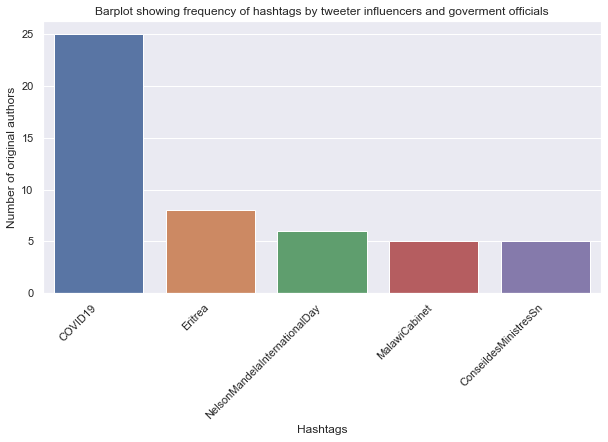

In [115]:
plt.figure(figsize=(10,5))
bplot = sns.barplot(x="hashtgs", y="original_author", data=df)
bplot.set_xticklabels(bplot.get_xticklabels(), rotation=45, horizontalalignment='right')
bplot.set(xlabel="Hashtags", ylabel="Number of original authors", 
          title="Barplot showing frequency of hashtags by tweeter influencers and goverment officials")
plt.savefig('hashtag_frequency.png', dpi=300, bbox_inches='tight')
plt.show()